# Tutorial2: Linear Regression

Simple linear regression example in TensorFlow. 
Reference [cs20si](http://web.stanford.edu/class/cs20si/lectures/slides_03.pdf)

In [1]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from util import get_log_path
import pandas as pd
import shutil
from IPython.display import Image


%matplotlib inline


# Linear Regression

Toy dataset  [Fire and Theft in Chicago](http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html)

The dataset consist of pairs (X,Y) where

- X = fires per 1000 housing units
- Y = thefts per 1000 population


within the same Zip code in the Chicago metro area.

Reference: U.S. Commission on Civil Rights

**Let us take a look in the dataset**

In [2]:
df = pd.read_excel('data/fire_theft.xls')
my_data = df.as_matrix()
df.head()

,X,Y
0,6.2,29
1,9.5,44
2,10.5,36
3,7.7,37
4,8.6,53


In [3]:
df.describe()

,X,Y
count,42.000000,42.000000
mean,12.692857,33.666667
std,9.667683,23.040438
min,2.000000,4.000000
25%,5.625000,22.000000
50%,10.500000,31.000000
75%,17.175000,39.750000
max,39.700000,147.000000


### We use the class Config to store all the hyperparameters

In [4]:
class Config():
    """
    Class to hold all model hyperparams.
    """
    def __init__(self,
                 learning_rate=0.001,
                 delta=1.0,
                 huber=False,
                 num_epochs=101,
                 show_epoch=10,
                 log_path=None):
        """
        :type learning_rate: float
        :type delta: float
        :type huber: boolean
        :type num_epochs: int
        :type show_epoch: int
        :type log_path: None or str
        """
        self.learning_rate = learning_rate
        self.delta = delta
        self.huber = huber
        self.num_epochs = num_epochs
        self.show_epoch = show_epoch
        if log_path is None:
            self.log_path = get_log_path()
        else:
            self.log_path = log_path

### Defining the linear regression model as a tf graph

In [5]:
class LinearRegression:
    """
    Class for the linear regression model
    """
    def __init__(self, config):
        """
        :type config: Config
        """
        self.learning_rate = config.learning_rate
        self.delta = config.delta
        self.huber = config.huber
        self.log_path = config.log_path
        self.build_graph()

    def create_placeholders(self):
        """
        Method for creating placeholders for input X (number of fire)
        and label Y (number of theft).
        """
        self.number_fire = tf.placeholder(tf.float32, shape=[], name="X")
        self.number_theft = tf.placeholder(tf.float32, shape=[], name="Y")

    def create_variables(self):
        """
        Method for creating weight and bias variables.
        """
        with tf.name_scope("Weights"):
            self.weight = tf.get_variable("w", dtype=tf.float32, initializer=0.)
            self.bias = tf.get_variable("b", dtype=tf.float32, initializer=0.)

    def create_summaries(self):
        """
        Method to create the histogram summaries for all variables
        """
        tf.summary.histogram('weights_summ', self.weight)
        tf.summary.histogram('bias_summ', self.bias)

    def create_prediction(self):
        """
        Method for creating the linear regression prediction.
        """
        with tf.name_scope("linear-model"):
            self.prediction = (self.number_fire * self.weight) + self.bias

    def create_MSE_loss(self):
        """
        Method for creating the mean square error loss function.
        """
        with tf.name_scope("loss"):
            self.loss = tf.square(self.prediction - self.number_theft)
            tf.summary.scalar("loss", self.loss)

    def create_Huber_loss(self):
        """
        Method for creating the Huber loss function.
        """
        with tf.name_scope("loss"):
            residual = tf.abs(self.prediction - self.number_theft)
            condition = tf.less(residual, self.delta)
            small_residual = 0.5 * tf.square(residual)
            large_residual = self.delta * residual - 0.5 * tf.square(self.delta)
            self.loss = tf.where(condition, small_residual, large_residual)
            tf.summary.scalar("loss", self.loss)

    def create_optimizer(self):
        """
        Method to create the optimizer of the graph
        """
        with tf.name_scope("optimizer"):
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            self.optimizer = opt.minimize(self.loss)

    def build_graph(self):
        """
        Method to build the computation graph in tensorflow
        """
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.create_placeholders()
            self.create_variables()
            self.create_summaries()
            self.create_prediction()
            if self.huber:
                self.create_Huber_loss()
            else:
                self.create_MSE_loss()
            self.create_optimizer()


In the graph above we defined two kinds of loss function. One of them is called [Huber loss](https://en.wikipedia.org/wiki/Huber_loss).

A quick review:

   
- $L_{\delta}(y,f(x)) =  \frac{1}{2}(y-f(x))^{2}$ if $|y-f(x)|\leq \delta$

- $L_{\delta}(y,f(x)) =  \delta|y-f(x)| -\frac{1}{2}\delta^{2}$ otherwise 


When we visualize the graph in tensorboard we find the following image

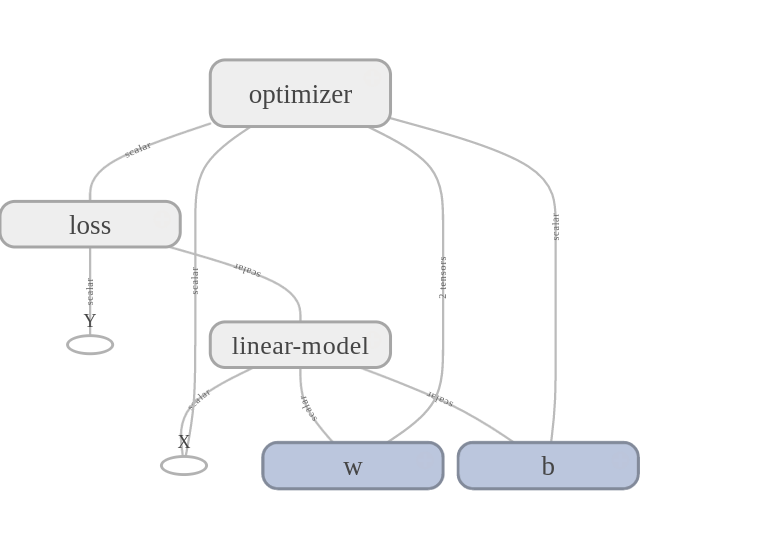

In [6]:
Image(filename="./images/graph_linear_regression.png") 

### Now we are going to define a function to train our model

In [7]:
def run_model(model, config, data, verbose=True):
    """
    Function to train the linear regression model

    :type model: LinearRegression
    :type config: Config
    :type data: np array
    :type verbose: boolean
    :rtype total_loss: float
    :rtype w: float
    :rtype b: float
    """
    n_samples = data.shape[0]
    num_epochs = config.num_epochs
    show_epoch = config.show_epoch
    log_path = model.log_path
    with tf.Session(graph=model.graph) as sess:
        if verbose:
            print('Start training\n')
        # functions to write the tensorboard logs
        summary_writer = tf.summary.FileWriter(log_path,sess.graph)
        all_summaries = tf.summary.merge_all()
        # initializing variables
        tf.global_variables_initializer().run()
        step = 0
        for i in range(num_epochs): # run num_epochs epochs
            total_loss = 0
            for x, y in data:
                step += 1
                
                feed_dict = {model.number_fire: x,
                             model.number_theft: y}
                
                _,loss,summary,w,b = sess.run([model.optimizer, # run optimizer to perform minimization
                                               model.loss,
                                               all_summaries,
                                               model.weight,
                                               model.bias], feed_dict=feed_dict)

                #writing the log
                summary_writer.add_summary(summary,step)
                summary_writer.flush()
                
                total_loss += loss
            if i % show_epoch == 0:
                print("\nEpoch {0}: {1}".format(i, total_loss/n_samples))
    if verbose:
        print("\n========= For TensorBoard visualization type ===========")
        print("\ntensorboard  --logdir={}\n".format(log_path))
    return total_loss,w,b 


**Training the model**

In [8]:
my_config = Config()
my_model = LinearRegression(my_config)
l,w,b = run_model(my_model, my_config, my_data)

Start training


Epoch 0: 2069.6319333978354

Epoch 10: 1924.5930823644712

Epoch 20: 1773.1024853109072

Epoch 30: 1666.1935385839038

Epoch 40: 1589.668056331575

Epoch 50: 1534.211797797609

Epoch 60: 1493.600210891061

Epoch 70: 1463.5996563179153

Epoch 80: 1441.2782130186733

Epoch 90: 1424.5748210840281

Epoch 100: 1412.0180716720365

========= For TensorBoard visualization type ===========

tensorboard  --logdir=./graphs/08-05-2017_16-16-43



In [9]:
# ! tensorboard  --logdir=

### After the model is constructed we can concentrate in hyperparameter optimization

For example the folowing function tries to find an optimal learning rate

In [10]:
def lr_tunning(data, number_of_exp=10, clean=True, huber=False):
    """
    Function that returns the best weights after training the model
    with some random values for the learning rate. 
    
    :type data: np array
    :type number_of_exp: int
    :type clean: boolean
    :type huber: boolean
    :rtype w: float
    :rtype b: float
    """
    if clean:
        shutil.rmtree("./graphs")
    n_samples = data.shape[0]
    LR = np.random.random_sample([number_of_exp])/1000
    LR.sort()
    best_loss = float('inf')
    for i, lr in enumerate(LR):
        log_path = './graphs/' + str(lr)
        header1 = "\n=============== ({0} of {1}) ===============\n".format(i + 1, number_of_exp)
        header2 = "  learning rate = {}".format(lr)
        header3 = "\n=========================================\n"
        print(header1 + header2 + header3)
        my_config = Config(log_path=log_path,
                           learning_rate=lr,
                           show_epoch=100,
                           huber=huber)
        my_model = LinearRegression(my_config)
        current_loss, current_w, current_b = run_model(my_model,
                                                       my_config,
                                                       data,
                                                       verbose=False)
        if current_loss < best_loss:
            best_loss, best_lr = current_loss, lr
            w, b = current_w, current_b
    print(header3)
    print("\nbest learning rate = {0}\nbest loss = {1}".format(best_lr,
                                                               best_loss/n_samples))
    print("\nFor TensorBoard visualization type")
    print("\ntensorboard  --logdir=/graphs/\n")
    return w, b

In [11]:
w,b = lr_tunning(my_data)


=============== (1 of 10) ===============
  learning rate = 0.0001500637623315817


Epoch 0: 793.2354119051071

Epoch 100: 504.38215058048564

=============== (2 of 10) ===============
  learning rate = 0.00019420282593258852


Epoch 0: 785.8810728589693

Epoch 100: 531.3583995737135

=============== (3 of 10) ===============
  learning rate = 0.00038042506531781793


Epoch 0: 896.7992439553851

Epoch 100: 675.2510775164479

=============== (4 of 10) ===============
  learning rate = 0.0005875298668462664


Epoch 0: 1141.6915899259704

Epoch 100: 859.4691136717087

=============== (5 of 10) ===============
  learning rate = 0.000738911106702933


Epoch 0: 1399.0185223704293

Epoch 100: 1024.0167353394486

=============== (6 of 10) ===============
  learning rate = 0.0007422949177233353


Epoch 0: 1405.7480145125162

Epoch 100: 1028.1393724293225

=============== (7 of 10) ===============
  learning rate = 0.0007848945585014333


Epoch 0: 1494.5839507806868

Epoch 100: 1081.94220823323

### Now we can use tensorboad to see which one is the best hyperparameter. To do so, we need to set logdir to the parent folder

In [12]:
#!tensorboard --logdir=./graphs

### Ploting the results

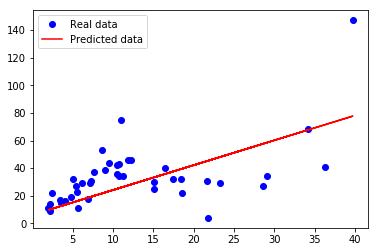

In [13]:
X, Y = my_data.T[0], my_data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

### We can repeat the model training using the Huber loss function

In [14]:
w,b = lr_tunning(my_data,huber=True)


=============== (1 of 10) ===============
  learning rate = 8.02995316503492e-05


Epoch 0: 32.90347622689747

Epoch 100: 16.49965476102772

=============== (2 of 10) ===============
  learning rate = 9.476519292177632e-05


Epoch 0: 32.85606370085762

Epoch 100: 16.450529192707368

=============== (3 of 10) ===============
  learning rate = 0.00034662227417862136


Epoch 0: 32.0305749915895

Epoch 100: 16.291906497352535

=============== (4 of 10) ===============
  learning rate = 0.0004063654664856775


Epoch 0: 31.84242305727232

Epoch 100: 16.255674382472144

=============== (5 of 10) ===============
  learning rate = 0.00041906082955413693


Epoch 0: 31.804961682785127

Epoch 100: 16.24802446579339

=============== (6 of 10) ===============
  learning rate = 0.0005565337071860053


Epoch 0: 31.427465448244696

Epoch 100: 16.16533487095564

=============== (7 of 10) ===============
  learning rate = 0.0005611795175024004


Epoch 0: 31.415608661692765

Epoch 100: 16.16255473075268


### Ploting again the results

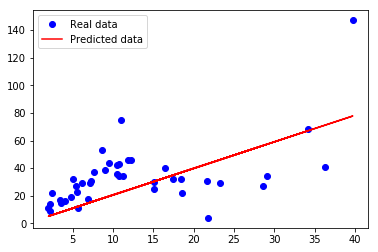

In [15]:
X, Y = my_data.T[0], my_data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()